# Social Networks & Online Markets Final Project ⛳

*   Gianmarco Fiorenza - 2086296
*   Mattia Girolami - 2076424


The chosen dataset is provided by **GloBi** (Global Biotic Interactions) and presents a list of interactions between species, along with the specific type of interaction. The dataset available on the GloBi website was unfortunately too large to be handled optimally, so we used the rGlobi library available for the `R`, which has a function that allows selecting only interactions within a specific geographic area. To achieve an optimal compromise between the number of nodes/edges and computational efficiency, we selected the entire European territory as the area.


---



In [1]:
!apt-get install -y python3-igraph
!pip install python-igraph
!pip install cairocffi

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  python3-texttable
The following NEW packages will be installed:
  python3-igraph python3-texttable
0 upgraded, 2 newly installed, 0 to remove and 45 not upgraded.
Need to get 1,449 kB of archives.
After this operation, 4,328 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 python3-texttable all 1.6.4-1 [11.4 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 python3-igraph amd64 0.9.9-1build1 [1,438 kB]
Fetched 1,449 kB in 2s (777 kB/s)
Selecting previously unselected package python3-texttable.
(Reading database ... 121925 files and directories currently installed.)
Preparing to unpack .../python3-texttable_1.6.4-1_all.deb ...
Unpacking python3-texttable (1.6.4-1) ...
Selecting previously unselected package python3-igraph.
Preparing to unpack .../python3-igraph_0.9.9-1bui

In [2]:
import math
import numpy as np
import igraph as ig
import pandas as pd
import networkx as nx
from google.colab import drive
from collections import Counter
import matplotlib.pyplot as plt
from scipy.linalg import eigvals
from collections import defaultdict
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import community.community_louvain as community_louvain

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
csv_path = '/content/drive/My Drive/europe_interaction.csv'
interactions_df = pd.read_csv(csv_path)

In [ ]:
interactions_df.head()

,Unnamed: 0,source_taxon_external_id,source_taxon_name,source_taxon_path,source_specimen_life_stage,interaction_type,target_taxon_external_id,target_taxon_name,target_taxon_path,target_specimen_life_stage,latitude,longitude,study_citation,study_source_citation
0,1,EOL_V2:1047915,Circus aeruginosus,Animalia | Chordata | Aves | Accipitriformes |...,NaN,preysOn,EOL_V2:1049340,Vanellus vanellus,Animalia | Chordata | Aves | Charadriiformes |...,NaN,NaN,NaN,NaN,NaN
1,2,EOL_V2:1049340,Vanellus vanellus,Animalia | Chordata | Aves | Charadriiformes |...,NaN,preyedUponBy,EOL_V2:1047915,Circus aeruginosus,Animalia | Chordata | Aves | Accipitriformes |...,NaN,NaN,NaN,NaN,NaN
2,3,EOL:599659,Echinus esculentus,Animalia | Echinodermata | Echinoidea | Camaro...,NaN,hasParasite,EOL_V2:68750,Philometra,Animalia | Arthropoda | Insecta | Lepidoptera ...,NaN,NaN,NaN,NaN,NaN
3,4,EOL_V2:68750,Philometra,Animalia | Arthropoda | Insecta | Lepidoptera ...,NaN,parasiteOf,EOL:599659,Echinus esculentus,Animalia | Echinodermata | Echinoidea | Camaro...,NaN,NaN,NaN,NaN,NaN
4,5,EOL:599659,Echinus esculentus,Animalia | Echinodermata | Echinoidea | Camaro...,NaN,hasParasite,EOL:4857088,Pelseneeria stylifera,Animalia | Mollusca | Gastropoda | | Eulimoid...,NaN,NaN,NaN,NaN,NaN


In [ ]:
interactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429410 entries, 0 to 429409
Data columns (total 14 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Unnamed: 0                  429410 non-null  int64  
 1   source_taxon_external_id    429410 non-null  object 
 2   source_taxon_name           428564 non-null  object 
 3   source_taxon_path           404642 non-null  object 
 4   source_specimen_life_stage  0 non-null       float64
 5   interaction_type            429410 non-null  object 
 6   target_taxon_external_id    429410 non-null  object 
 7   target_taxon_name           428564 non-null  object 
 8   target_taxon_path           404642 non-null  object 
 9   target_specimen_life_stage  0 non-null       float64
 10  latitude                    0 non-null       float64
 11  longitude                   0 non-null       float64
 12  study_citation              0 non-null       float64
 13  study_source_c

# Building the graph

In [5]:
interaction_graph = nx.from_pandas_edgelist(interactions_df, source='source_taxon_name', target='target_taxon_name', edge_attr='interaction_type')

In [29]:
degrees = dict(interaction_graph.degree())

sorted_nodes = sorted(degrees, key=degrees.get, reverse=True)

top_10_nodes = sorted_nodes[:10]

print("Top 10 nodes with highest degree:")
for node in top_10_nodes:
  print(f"\t{node}: {degrees[node]}")


Top 10 nodes with highest degree:
	Apis mellifera: 764
	Quercus: 639
	Detritus: 620
	Lithobius: 613
	Quercus robur: 594
	Melanogrammus aeglefinus: 575
	Gadus morhua: 513
	Staphylinidae: 513
	Salix: 503
	Acari: 493


As we can see there are 'problematic' nodes such as 'nan' and 'Substrate Undetermined', so we decided to remove them.

In [7]:
# Drop nodes with label "Substrate Undetermined" or NaN
nan_node = top_10_nodes[1]
interaction_graph.remove_nodes_from(['Substrate Undetermined'])
interaction_graph.remove_node(nan_node)

In [8]:
connected_components = list(nx.connected_components(interaction_graph))

nodes_for_component = list()

print(f"Number of connected components: {len(connected_components)}")

for component in connected_components:
  nodes_for_component.append(len(component))

Number of connected components: 3349


Studying the connected components of the graph, we can clearly see that there is a considerably larger connected one.

In [9]:
for n, i in enumerate(sorted(nodes_for_component, reverse=1)[:10]):
  print(f"{n+1} connected component with {i} nodes.")

1 connected component with 39227 nodes.
2 connected component with 19 nodes.
3 connected component with 15 nodes.
4 connected component with 14 nodes.
5 connected component with 12 nodes.
6 connected component with 12 nodes.
7 connected component with 11 nodes.
8 connected component with 11 nodes.
9 connected component with 9 nodes.
10 connected component with 9 nodes.


<ipython-input-10-ca611c466789>:12: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 30)
<ipython-input-10-ca611c466789>:13: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 10**4)


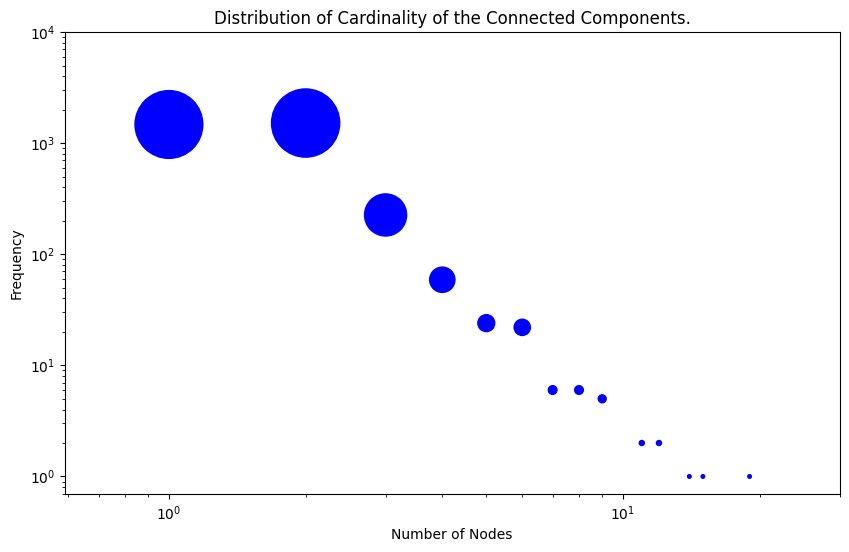

In [10]:
component_degree_count = np.bincount(nodes_for_component)
nodes_in_component = np.arange(len(component_degree_count))

sizes = 10**3 * np.log1p(component_degree_count / 150)


plt.figure(figsize=(10, 6))
plt.scatter(nodes_in_component,component_degree_count, s=sizes, marker='o', color='b')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Number of Nodes')
plt.xlim(0, 30)
plt.ylim(0, 10**4)
plt.ylabel('Frequency')
plt.title('Distribution of Cardinality of the Connected Components.')
plt.show()

# Degree Distribution of the Whole Graph

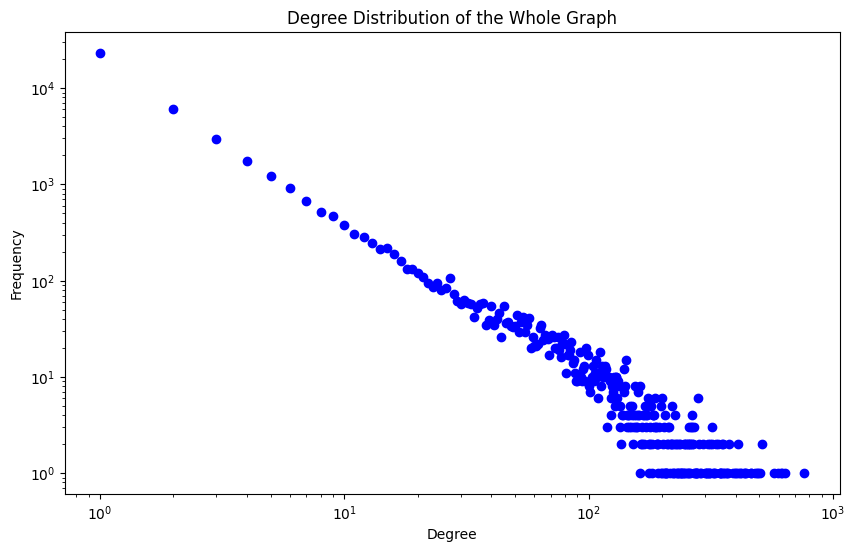

In [11]:
degree_sequence = [d for n, d in interaction_graph.degree()]
degree_count = np.bincount(degree_sequence)
degrees = np.arange(len(degree_count))

nonzero_degrees = degrees[degree_count > 0]
nonzero_counts = degree_count[degree_count > 0]

plt.figure(figsize=(10, 6))
plt.scatter(nonzero_degrees, nonzero_counts, marker='o', color='b')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution of the Whole Graph')
plt.show()

Our network exhibit a clear **scale-free** distribution

# Exploration of the Dominant Connected Component

In order to work with connectivity metrics and also because the dimension of the largest connected component is significatly larger than the others, we choose to focus on this one.

In [12]:
# Get the largest connected component
largest_component = max(connected_components, key=len)

largest_graph = interaction_graph.subgraph(largest_component)

print(f"Number of nodes in the largest connected component: {largest_graph.number_of_nodes()}")
print(f"Number of edges in the largest connected component: {largest_graph.number_of_edges()}")

Number of nodes in the largest connected component: 39227
Number of edges in the largest connected component: 183609


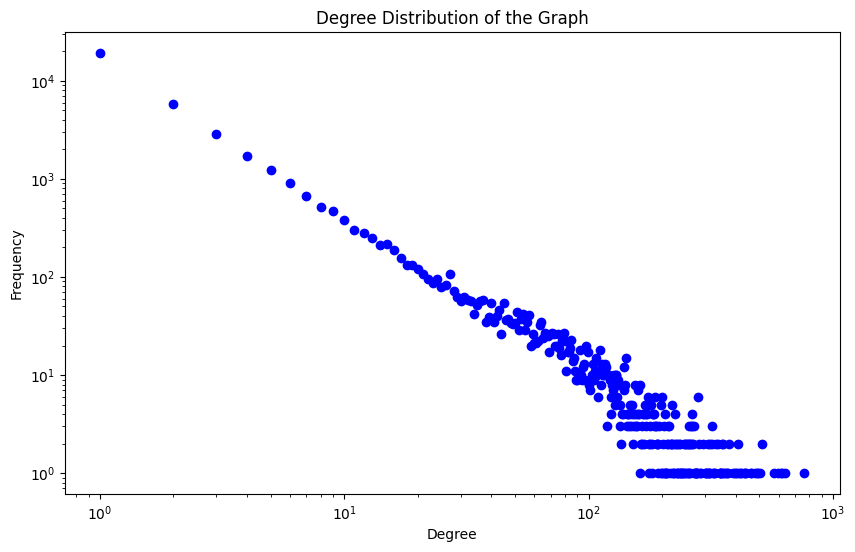

In [13]:
degree_sequence_giga_component = [d for n, d in largest_graph.degree()]
degree_count_giga_component = np.bincount(degree_sequence_giga_component)
degrees_giga_component = np.arange(len(degree_count_giga_component))

plt.figure(figsize=(10, 6))
plt.scatter(degrees_giga_component, degree_count_giga_component, marker='o', color='b')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution of the Graph')
plt.show()

## Centrality Measures

In order to compute centrality measures efficiently, we used iGraph instead of NetworkX.

In [14]:
# Conversion from NetworkX to iGraph graph.

interactions_igraph = ig.Graph()

interactions_igraph.add_vertices(list(largest_graph.nodes()))

edges = list(largest_graph.edges())
interactions_igraph.add_edges(edges)

for node, attributes in largest_graph.nodes(data=True):
    for key, value in attributes.items():
        interactions_igraph.vs[node][key] = value

for edge in largest_graph.edges(data=True):
    source, target, attributes = edge
    eid = interactions_igraph.get_eid(source, target)
    for key, value in attributes.items():
        interactions_igraph.es[eid][key] = value

print(interactions_igraph.summary())

IGRAPH UN-- 39227 183609 -- 
+ attr: name (v), interaction_type (e)


In [ ]:
diameter = interactions_igraph.diameter()
print(f"Diameter of the graph: {diameter}")

Diameter of the graph: 21


In [15]:
def get_top_5_nodes(centrality_values):
    centrality_with_nodes = list(enumerate(centrality_values))
    centrality_with_nodes.sort(key=lambda x: x[1], reverse=True)
    return centrality_with_nodes[:5]

In [27]:
def print_top_5(centrality_name, top_5):
  print(f"Top 5 nodes with the highest {centrality_name}:")
  for node, value in top_5:
    print(f"\t{interactions_igraph.vs[node]['name']} -> {value}")
  print()

In [17]:
degree_centrality = interactions_igraph.degree()
closeness_centrality = interactions_igraph.closeness()
eigenvector_centrality = interactions_igraph.eigenvector_centrality()
pagerank = interactions_igraph.pagerank()
betweenness_centrality = interactions_igraph.betweenness()

In [20]:
num_nodes = interactions_igraph.vcount()
normalized_betweenness = [nb / (((num_nodes-1) * (num_nodes - 2))/2) for nb in betweenness_centrality]

In [28]:
top_5_degree = get_top_5_nodes(degree_centrality)
top_5_closeness = get_top_5_nodes(closeness_centrality)
top_5_eigenvector = get_top_5_nodes(eigenvector_centrality)
top_5_pagerank = get_top_5_nodes(pagerank)
top_5_betweenness = get_top_5_nodes(normalized_betweenness)


print_top_5("Degree Centrality", top_5_degree)
print_top_5("Closeness Centrality", top_5_closeness)
print_top_5("Eigenvector Centrality", top_5_eigenvector)
print_top_5("PageRank", top_5_pagerank)
print_top_5("Betweenness Centrality", top_5_betweenness)

Top 5 nodes with the highest Degree Centrality:
	Apis mellifera -> 764
	Quercus -> 639
	Detritus -> 620
	Lithobius -> 613
	Quercus robur -> 594

Top 5 nodes with the highest Closeness Centrality:
	Apis mellifera -> 0.3244392245087011
	Acari -> 0.3068006726369716
	Passer domesticus -> 0.30418834769257014
	Harmonia axyridis -> 0.3035786149893199
	Vespa velutina -> 0.30283799641776293

Top 5 nodes with the highest Eigenvector Centrality:
	Atheta -> 1.0
	Lithobius -> 0.9819862507607471
	Staphylinidae -> 0.8605573558144123
	Athous subfuscus -> 0.8588905565920536
	Robertus lividus -> 0.8463702838418207

Top 5 nodes with the highest PageRank:
	Quercus -> 0.0029798529555988464
	Quercus robur -> 0.00251586036216449
	Apis mellifera -> 0.0023979727579650583
	indet. -> 0.0021589028008475834
	Salix -> 0.0021387450670535394

Top 5 nodes with the highest Betweenness Centrality:
	Apis mellifera -> 0.08228407471062364
	Alnus glutinosa -> 0.04815770722304245
	Acari -> 0.039755387523890656
	Plantae -> 0.

In [38]:
avg_clustering_coefficient = interactions_igraph.transitivity_avglocal_undirected(mode='zero')

print("Global Clustering Coefficient:")
print(f"\t{avg_clustering_coefficient}")

Global Clustering Coefficient:
	0.0447260636356384


# Partitions analysis

We performed community detection using the `Louvain` partition algorithm.

 Setting the seed to `123` for reproducibiity, the number of detected communities is equal to **121**

In [40]:
np.random.seed(123)
partition = community_louvain.best_partition(largest_graph)


num_communities = len(set(partition.values()))
print(f"Number of communities: {num_communities}")

Number of communities: 121


In [41]:
community_dict = defaultdict(list)
for node, community in partition.items():
    community_dict[community].append(node)

community_sizes = {community: len(nodes) for community, nodes in community_dict.items()}

sizes = list(community_sizes.values())
size_counts = defaultdict(int)
for size in sizes:
    size_counts[size] += 1

unique_sizes = list(size_counts.keys())
frequencies = list(size_counts.values())

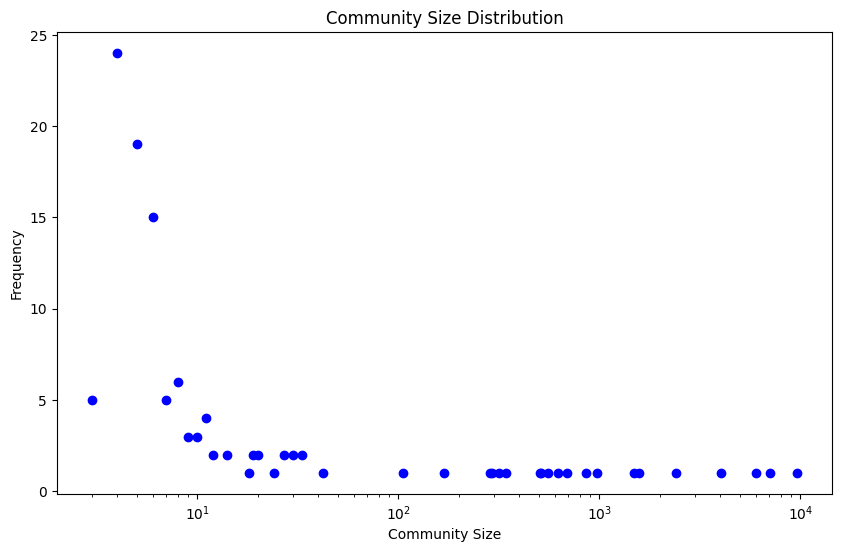

In [47]:
plt.figure(figsize=(10, 6))
plt.scatter(unique_sizes, frequencies, marker='o', color='b')
plt.xscale('log')
plt.xlabel('Community Size')
plt.ylabel('Frequency')
plt.title('Community Size Distribution')
plt.show()

### Modularity

The species interaction network exhibits a modularity score of 0.75, indicating a highly structured ecosystem with well-defined communities. Each community shows strong internal interactions among species, suggesting distinct ecological roles or functional groups, while interactions between communities are relatively sparse, reflecting distinct ecological niches.

In [ ]:
modularity = community_louvain.modularity(partition, largest_graph)
print(f"Modularity of the partition: {modularity}")

### Principal Components Analysis

In [48]:
top_partitions = sorted(community_dict.items(), key=lambda x: len(x[1]), reverse=True)[:20]
interaction_dict = {}

for part, nodes in top_partitions:
  subgraph = largest_graph.subgraph(nodes)
  edge_types = [edge['interaction_type'] for _,_,edge in subgraph.edges(data=True)]
  interaction_dict[part] = edge_types

In [49]:
communities = []
attributes = set()

for k, v in interaction_dict.items():
  communities.append(k)
  attributes.update(v)

attributes = list(attributes)

In [50]:
frequencies = {}
for community, attrs in interaction_dict.items():
    attr_count = Counter(attrs)
    frequencies[community] = [attr_count.get(attr, 0) for attr in attributes]

data = pd.DataFrame.from_dict(frequencies, orient='index', columns=attributes)
data = data.div(data.sum(axis=1), axis=0)
data[data < 0.03] = 0
data = data.div(data.sum(axis=1), axis=0)
data = data.round(2)

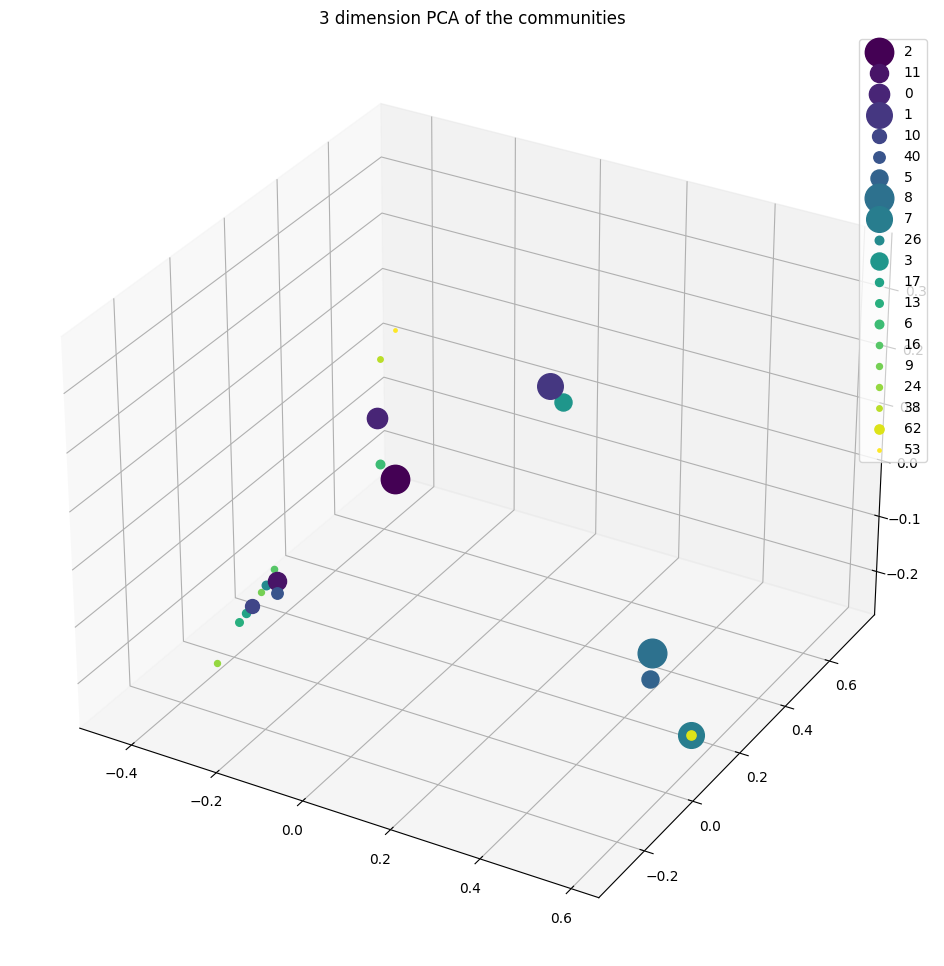

In [100]:
colors = plt.cm.viridis(np.linspace(0, 1, len(data)))
community_colors = {community: colors[i] for i, community in enumerate(communities)}

pca = PCA(n_components=3)
pca.fit(data)
df_pca = pca.transform(data)

community_sizes = [len(interaction_dict[community]) for community in communities]
community_sizes_dict = {community: size for community, size in zip(communities, community_sizes)}

scaled_sizes = [size/20 if size<1000 else (size/32 if size<5000 else size/70) for size in community_sizes]

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

for i, community in enumerate(communities):
    ax.scatter(df_pca[i, 0], df_pca[i, 1], df_pca[i, 2], s=scaled_sizes[i], color=community_colors[community], label=community)

ax.legend()
plt.title('3 dimension PCA of the communities')
plt.show()

In [64]:
var_coverage = sum([x for x in pca.explained_variance_ratio_])
print(f"The explained variance ratio is: {pca.explained_variance_ratio_}")
print(f"Covering a total variance of: {round(var_coverage, 3)*100}%")

The explained variance ratio is: [0.49574145 0.28256024 0.12378544]
Covering a total variance of: 90.2%


We conducted a Principal Component Analysis that provides a comprehensive representation, capturing approximately 90% of the variance. We examined the number of distinct interactions within each community to assess whether the `interaction_type` was closely associated with the partitioning defined by the Louvain algorithm. The plot displays various communities, where dot size corresponds to the size of each respective community.

It is evident that there is not a strict relationship, although the more populous communities are clearly distinguishable in this representation.

### Top Hubs per Partition

In [67]:
# This function returns the top 2 hubs (in terms of degree centrality) for each partition

def top_hubs_per_partition(partition, graph):
  hubs_by_partition = {}
  for community in set(partition.values()):
    nodes_in_partition = [node for node, part in partition.items() if part == community]
    subgraph = graph.subgraph(nodes_in_partition)

    degrees = nx.degree_centrality(subgraph)
    sorted_nodes = sorted(degrees, key=degrees.get, reverse=True)

    top_hubs = [(node, degrees[node]) for node in sorted_nodes[:2]]
    hubs_by_partition[community] = top_hubs
  return hubs_by_partition

In [70]:
top_hubs = top_hubs_per_partition(partition, largest_graph)

for part_, hubs in top_hubs.items():
  print(f"Partition {part_}:")
  for hub, degree in hubs:
    print(f"\t- {hub}: {round(degree, 5)}")

Partition 0:
	- Vulpes vulpes: 0.05876
	- Acari: 0.05195
Partition 1:
	- Melanogrammus aeglefinus: 0.14247
	- Gadus morhua: 0.12581
Partition 2:
	- Apis mellifera: 0.06727
	- Bombus pascuorum: 0.03217
Partition 3:
	- Salmo trutta: 0.32201
	- Gammarus pulex: 0.3123
Partition 4:
	- U.: 1.0
	- Proisotoma clavipila: 0.2
Partition 5:
	- Nyctalus leisleri: 0.17013
	- Lepidoptera: 0.08038
Partition 6:
	- Chalcidoidea: 0.13439
	- Pteromalus dolichurus: 0.09289
Partition 7:
	- Lithobius: 0.66395
	- Staphylinidae: 0.50116
Partition 8:
	- Agalenatea redii: 0.41598
	- Aculepeira ceropegia: 0.41291
Partition 9:
	- Galium mollugo: 0.07256
	- Puccinia bullata: 0.05994
Partition 10:
	- Puccinia graminis: 0.03857
	- Puccinia coronata: 0.0336
Partition 11:
	- Quercus: 0.07116
	- Quercus robur: 0.06504
Partition 12:
	- Chamaerops humilis: 0.3125
	- Graphiola phoenicis: 0.25
Partition 13:
	- Microbotryum violaceum: 0.09804
	- Puccinia arenariae: 0.09216
Partition 14:
	- Urophlyctis pulposa: 0.66667
	- Che

### Analysis of the largest partitions

In [72]:
partition_size = {}
for node, part_id in partition.items():
    if part_id not in partition_size:
        partition_size[part_id] = 0
    partition_size[part_id] += 1

sorted_partitions = sorted(partition_size.items(), key=lambda x: x[1], reverse=True)
top_community_ids = [part_id for part_id, size in sorted_partitions[:20]]

# Create subgraphs for the top 20 communities
top_community_subgraphs = []
for part_id in top_community_ids:
    nodes_in_community = [node for node, part in partition.items() if part == part_id]
    subgraph = largest_graph.subgraph(nodes_in_community)
    top_community_subgraphs.append(subgraph)

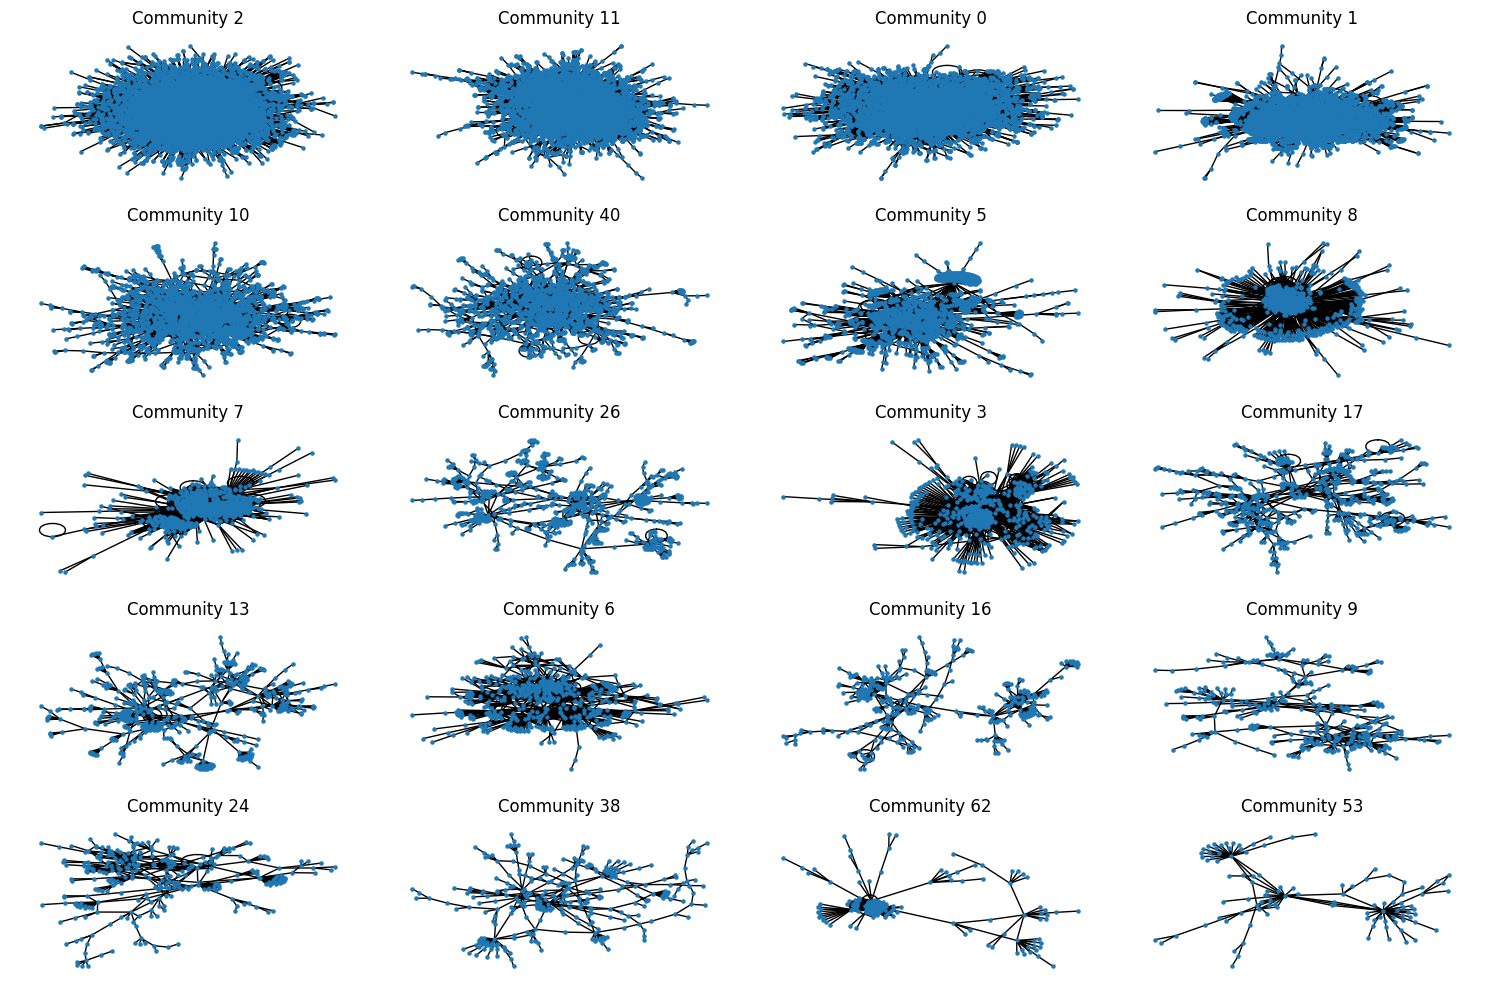

In [73]:
plt.figure(figsize=(15, 10))

for i, subgraph in enumerate(top_community_subgraphs):
    plt.subplot(5, 4, i+1)
    nx.draw(subgraph, with_labels=False, node_size=5)
    plt.title(f"Community {top_community_ids[i]}")

plt.tight_layout()
plt.show()

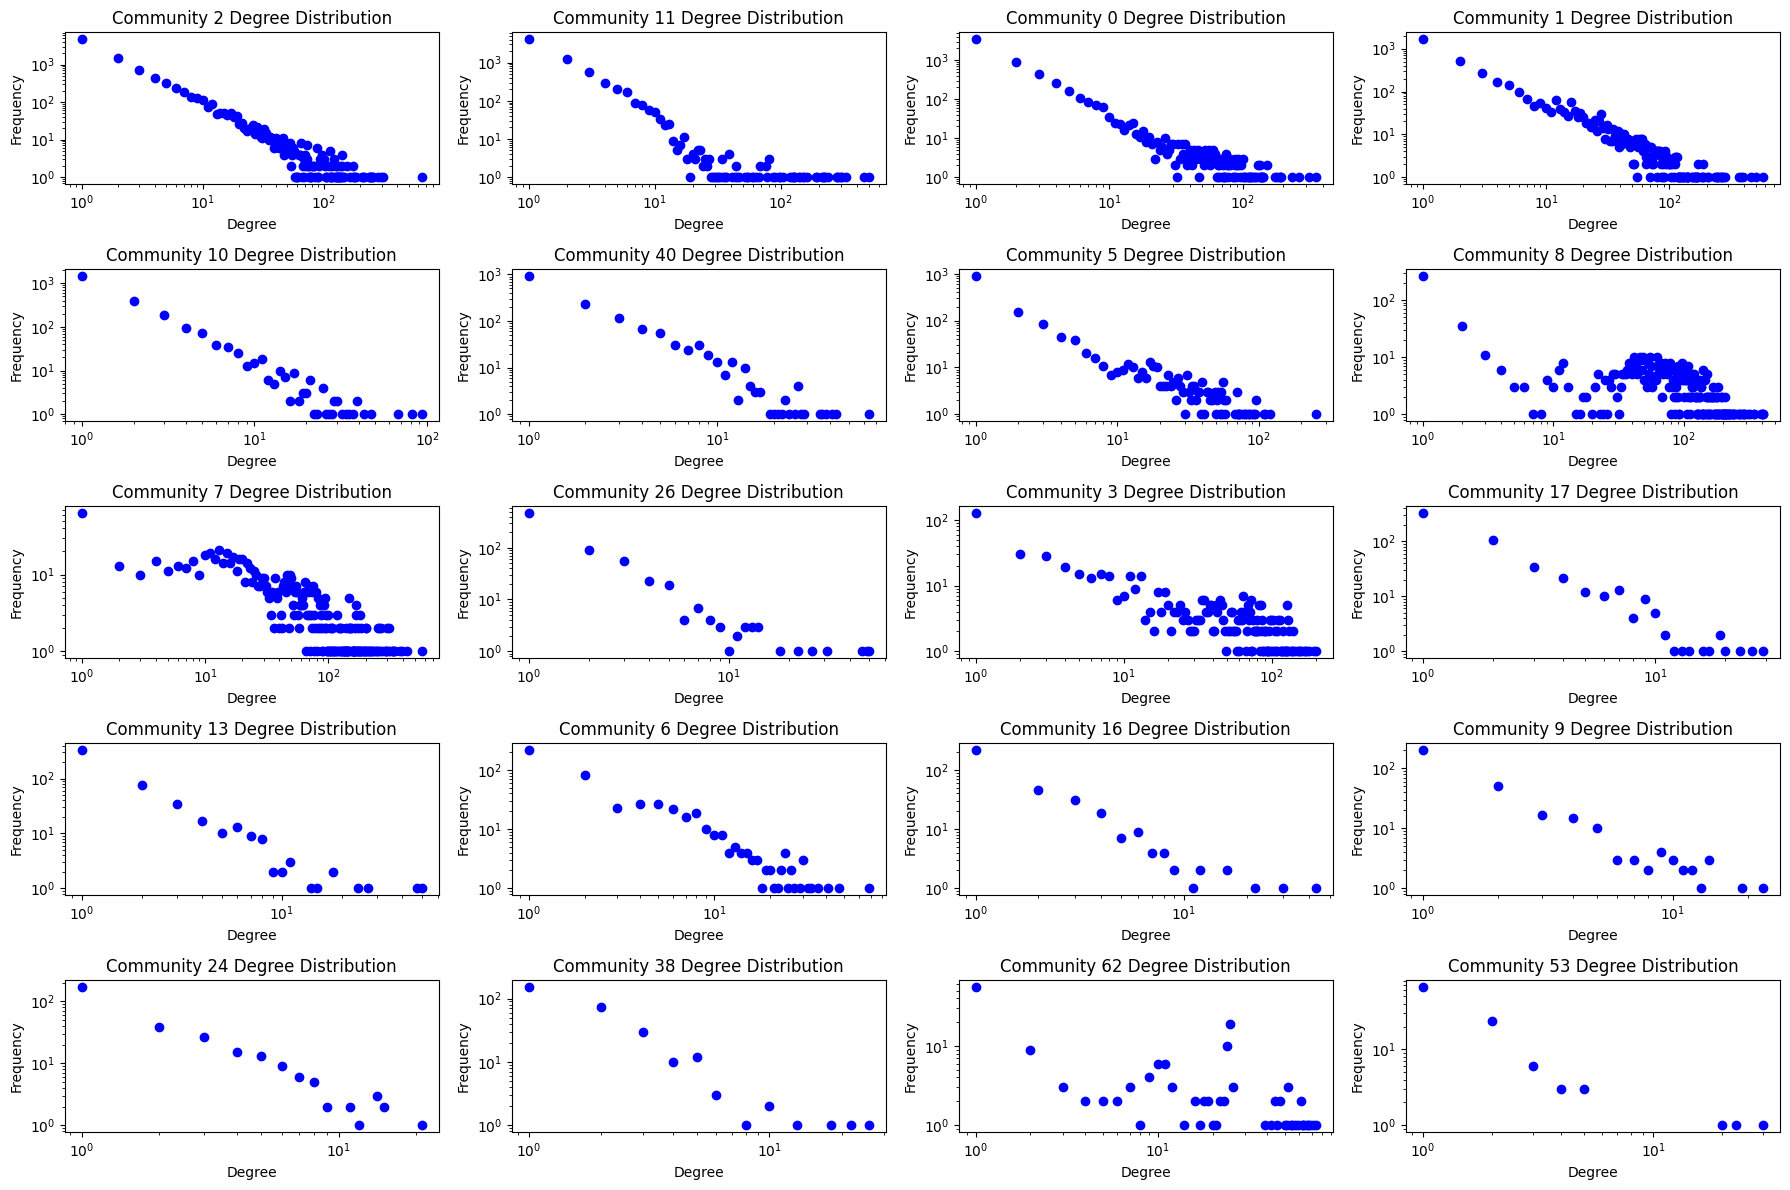

In [74]:
# Plot degree distribution for each subgraph
plt.figure(figsize=(18, 12))

for i, subgraph in enumerate(top_community_subgraphs):
    plt.subplot(5, 4, i+1)

    degrees = [deg for node, deg in subgraph.degree()]
    degree_values = sorted(set(degrees))
    degree_count = [degrees.count(deg) for deg in degree_values]

    plt.scatter(degree_values, degree_count, marker='o', color='b')
    plt.xscale('log')
    plt.yscale('log')

    plt.title(f"Community {top_community_ids[i]} Degree Distribution")
    plt.xlabel('Degree')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

We can see that both the overall network's degree distribution and the degree distribution within communities follow power laws, it suggests a particular organization of the network where the scale-free nature is preserved not only globally but also at a finer-grained community level.

## Analysis of the biggest community

Since a power-law degree distribution has emerged again, first on the entire graph, then within the communities detected by the Louvain algorithm, and we will see this structure reappear even within the graph division by layer, we decided to see if this property is also present at a more granular level.

Therefore, we re-applied the Louvain algorithm on the largest community obtained previously and studied the degree distributions of the communities thus obtained.

In [75]:
biggest_community = top_community_subgraphs[0]

np.random.seed(123)
partitions_of_biggest_community = community_louvain.best_partition(biggest_community)

num_communities_biggest_c = len(set(partitions_of_biggest_community.values()))
print(f"Number of communities: {num_communities_biggest_c}")

Number of communities: 43


In [76]:
modularity_biggest_comm = community_louvain.modularity(partitions_of_biggest_community, biggest_community)
print(f"Modularity of the partition: {modularity_biggest_comm}")

Modularity of the partition: 0.4744779848734145


In [80]:
partition_size_ = {}
for node, part_id in partitions_of_biggest_community.items():
    if part_id not in partition_size_:
        partition_size_[part_id] = 0
    partition_size_[part_id] += 1

sorted_partitions_ = sorted(partition_size_.items(), key=lambda x: x[1], reverse=True)
top_community_ids_ = [part_id for part_id, size in sorted_partitions_[:6]]

# Create subgraphs for the top 6 communities
top_community_subgraphs_ = []
for part_id in top_community_ids_:
    nodes_in_community = [node for node, part in partitions_of_biggest_community.items() if part == part_id]
    subgraph = biggest_community.subgraph(nodes_in_community)
    top_community_subgraphs_.append(subgraph)


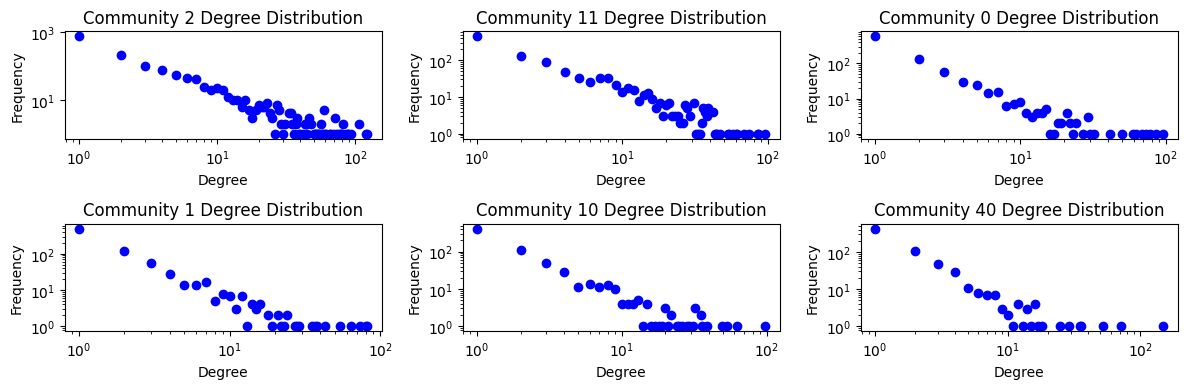

In [81]:
# Plot degree distribution for each subgraph
plt.figure(figsize=(12, 4))

for i, subgraph in enumerate(top_community_subgraphs_):
    plt.subplot(2, 3, i+1)

    degrees = [deg for node, deg in subgraph.degree()]
    degree_values = sorted(set(degrees))
    degree_count = [degrees.count(deg) for deg in degree_values]

    plt.scatter(degree_values, degree_count, marker='o', color='b')
    plt.xscale('log')
    plt.yscale('log')

    plt.title(f"Community {top_community_ids[i]} Degree Distribution")
    plt.xlabel('Degree')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Also communities of the biggest community shows a **power law distribution**

# Small World property

In [83]:
# Average path length and clustering coefficient of our graph
average_path_length = interactions_igraph.average_path_length()
clustering_coefficient = interactions_igraph.transitivity_avglocal_undirected(mode='zero')

# Random graph with the same number of nodes and edges using the Erdős-Rényi model
random_graph = ig.Graph.Erdos_Renyi(n = interactions_igraph.vcount(), m = interactions_igraph.ecount())

# Calculate the average path length and clustering coefficient of the random graph
random_average_path_length = random_graph.average_path_length()
random_clustering_coefficient = random_graph.transitivity_avglocal_undirected()


print(f"Average Path Length of the graph: {average_path_length}")
print(f"Clustering Coefficient of the graph: {clustering_coefficient}")
print(f"Average Path Length of the random graph: {random_average_path_length}")
print(f"Clustering Coefficient of the random graph: {random_clustering_coefficient}")

Average Path Length of the graph: 5.015092653391991
Clustering Coefficient of the graph: 0.0447260636356384
Average Path Length of the random graph: 4.97448704300662
Clustering Coefficient of the random graph: 0.00025430406009969384


In [88]:
#Small-World Indexes

sigma = clustering_coefficient/random_clustering_coefficient
print(f"Small-World Index σ: {sigma}")

omega = average_path_length/random_average_path_length
print(f"Small-World Index ω: {omega}")
print()

SWI = np.sqrt(omega*sigma)
print(f"Small-World Index SWI: {SWI}")

Small-World Index σ: 175.87632544326902
Small-World Index ω: 1.008162773374283

Small-World Index SWI: 13.315853860333707


To assess the small-world nature of our graph, we used a metric known as the `Small World Index (SWI)`, where values farther from $1$ indicate a more small-world structure of the graph.

At first glance, our small worldness score is approximately $13$. However, upon analyzing the $\omega$ and $\sigma$ components of the metric, we observe that the dominant component is $\omega$, which measures how clustered the graph is compared to a random graph of the same size.

We expected this from the high modularity of the communities, but at the same time we observe a communication capacity very similar to that of a random graph.

$$ \omega = \frac{L}{L_r} \ , \hspace{10mm} \sigma = \frac{L}{L_r} \ , \hspace{10mm} \text{SWI} = \sqrt{\omega \cdot \sigma} $$


# Hierarchical Structure of the Network

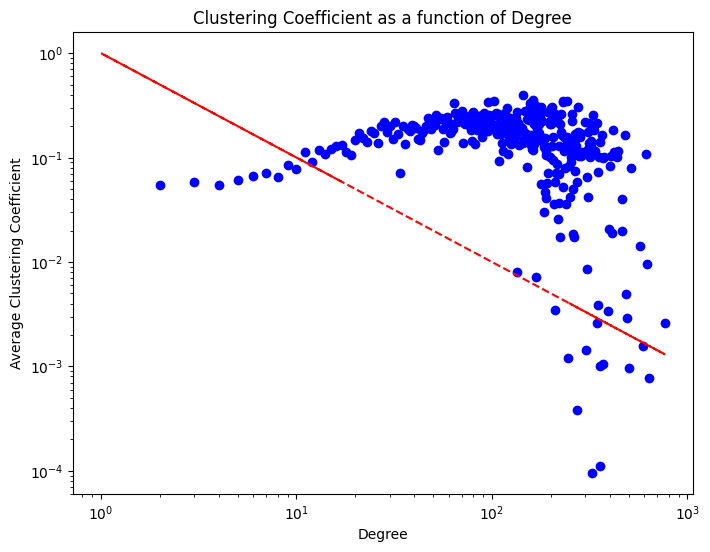

In [99]:
clustering_coeffs = interactions_igraph.transitivity_local_undirected(mode='zero')
degree_clustering = {}

for node, deg in enumerate(degree_centrality):
    if deg not in degree_clustering:
        degree_clustering[deg] = []
    degree_clustering[deg].append(clustering_coeffs[node])
avg_degree_clustering = {k: np.mean(v) for k, v in degree_clustering.items()}
deg, clust = zip(*avg_degree_clustering.items())

plt.figure(figsize=(8, 6))
plt.plot(deg, clust, 'bo')

k_values = np.array(deg, dtype=float)
C_k_fit = k_values**-1
plt.plot(k_values, C_k_fit, 'r--', label='$C(k) = k^{-1}$')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree')
plt.ylabel('Average Clustering Coefficient')
plt.title('Clustering Coefficient as a function of Degree')
plt.show()

Based on the analysis following the methodology from "[Scale-Free and Hierarchical Structures in Complex Networks](https://www.google.com/url?q=https%3A%2F%2Fregan.med.harvard.edu%2Fpdf%2Fpublications%2FScale-free_and_Hierarchical_Structures_in_Complex_Networks__LectNotesP.pdf)", our findings indicate that the network does not exhibit a hierarchical structure as expected. This deviation suggests potential divergences in network topology or dynamics compared to the theoretical framework proposed in the paper.

As mentioned in the paper, some networks with strong geographical constraints generally lack hierarchical structures due to the stringent constraints on network topology.

# Percolation and Network Resilience Analysis

In [ ]:
percolated_g = interactions_igraph.copy()
percolated_g.delete_vertices(top_5_betweenness[0][0])

components = percolated_g.components()

num_components = components.summary()[0]

In [98]:
percolated_g = interactions_igraph.copy()
percolated_g.delete_vertices(top_5_betweenness[0][0])

clusters = percolated_g.connected_components()

num_components = len(clusters)
print(f"Number of connected components: {num_components}")
print()

component_sizes = clusters.sizes()
print("Sizes of connected components:")
for k,v in Counter(component_sizes).items():
  print(f"\t{v} components with {k} nodes.")

Number of connected components: 72

Sizes of connected components:
	1 components with 39150 nodes.
	67 components with 1 nodes.
	1 components with 3 nodes.
	3 components with 2 nodes.


## Resilence and Vulnerability of the Network

In [108]:
def extincion_resilience(G):

  clusters = G.connected_components()

  component_sizes = clusters.sizes()
  S = max(component_sizes)

  s = np.mean(component_sizes)

  return (S, s)

In [111]:
centrality_with_nodes = list(enumerate(betweenness_centrality))
centrality_with_nodes.sort(key=lambda x: x[1], reverse=True)

percolated_graph = interactions_igraph.copy()
k = 10000

plotting_list = {}

for i, node in enumerate(centrality_with_nodes[:k]):
  if node[0] in percolated_graph.vs.indices:
    percolated_graph.delete_vertices(node[0])
    plotting_list[i] = extincion_resilience(percolated_graph)

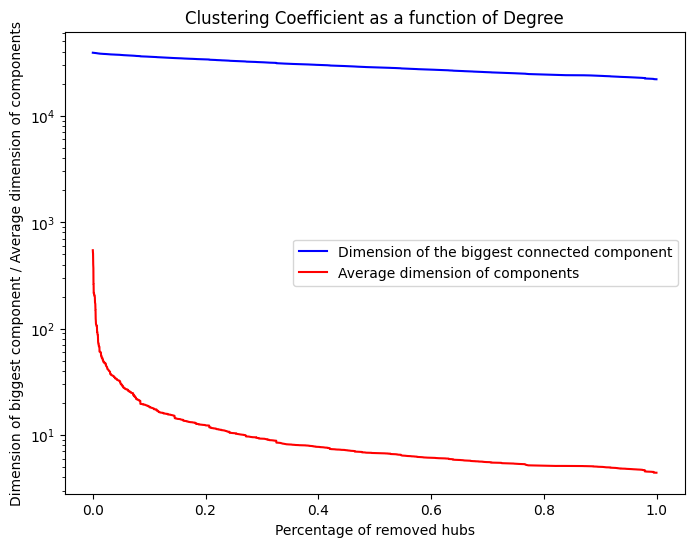

In [112]:
dim_bigcomps = [x[0] for x in plotting_list.values()]
avg_comps = [x[1] for x in plotting_list.values()]

plt.figure(figsize=(8, 6))
xax = [key/k for key in plotting_list.keys()]
plt.plot(xax, dim_bigcomps, color='blue', label = 'Dimension of the biggest connected component')
plt.plot(xax, avg_comps, color='red', label ='Average dimension of components')

plt.xlabel('Percentage of removed hubs')
plt.yscale('log')
plt.ylabel('Dimension of biggest component / Average dimension of components')
plt.title('Clustering Coefficient as a function of Degree')
plt.legend()
plt.show()

We attempted to observe how the size of the biggest connected component and the average size of the components change while we sequentially remove the k nodes with the highest betweenness centrality. The plot shows the percentage proportion of the number of hubs removed on the x-axis.

As can be seen from the trend of the biggest connected component, it is particularly structured, and despite the removal of numerous nodes, it cannot be divided into multiple components. On the other hand, the trend of the average component size shows a steep decline at first, then begins to stabilize.

In conclusion, the graph demonstrates strong resistance to "targeted attacks."

# MultiLayer Network

## Interactions distribution

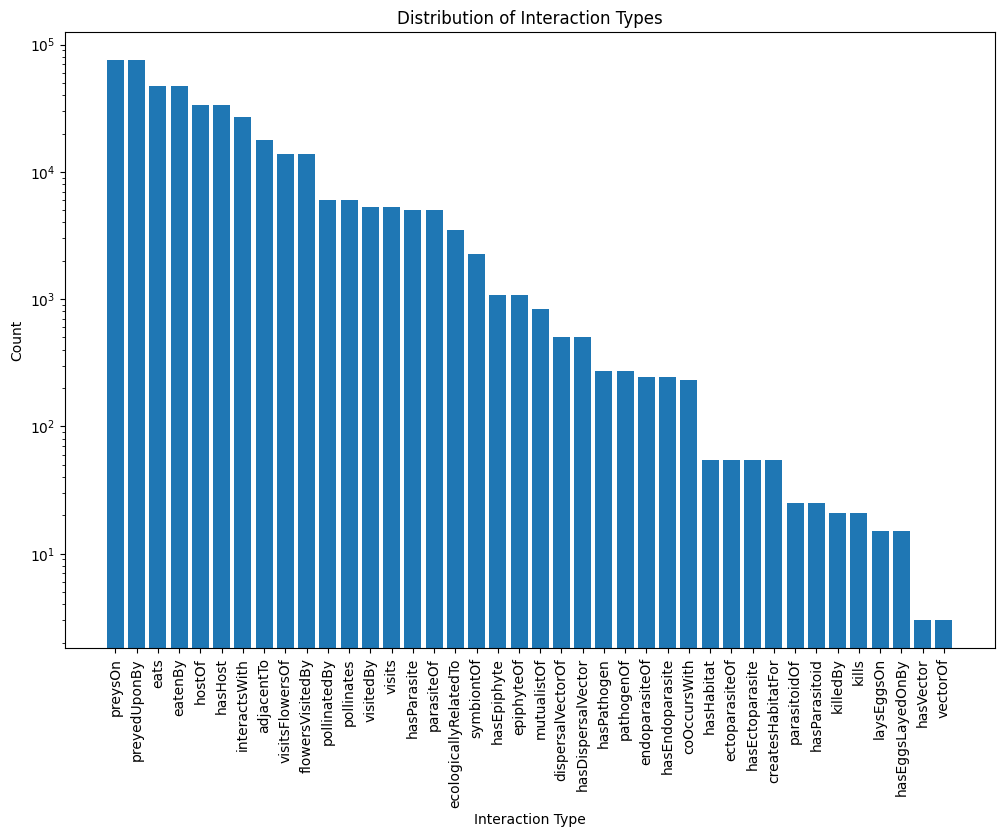

In [113]:
interaction_type_counts = interactions_df['interaction_type'].value_counts()

plt.figure(figsize=(12, 8))

plt.bar(interaction_type_counts.index, interaction_type_counts.values)
plt.xlabel('Interaction Type')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.yscale('log')
plt.title('Distribution of Interaction Types')
plt.show()

In [132]:
layers = {}
interaction_types = interactions_df['interaction_type'].unique()

# Create a graph for each interaction type
for interaction in interaction_types:
    layers[interaction] = nx.DiGraph()
    sub_df = interactions_df[interactions_df['interaction_type'] == interaction]

    for _, row in sub_df.iterrows():
      source_taxon = row['source_taxon_name']
      target_taxon = row['target_taxon_name']

      if (not pd.isna(source_taxon) and source_taxon != 'Substrate Undetermined') and \
          (not pd.isna(target_taxon) and target_taxon != 'Substrate Undetermined'):
          layers[interaction].add_edge(source_taxon, target_taxon)

In [115]:
for interaction in interaction_types:
    print(f"Layer: {interaction}, Number of nodes: {layers[interaction].number_of_nodes()}, Number of edges: {layers[interaction].number_of_edges()}")

Layer: preysOn, Number of nodes: 5201, Number of edges: 73913
Layer: preyedUponBy, Number of nodes: 5201, Number of edges: 73913
Layer: hasParasite, Number of nodes: 2784, Number of edges: 4945
Layer: parasiteOf, Number of nodes: 2784, Number of edges: 4945
Layer: visitsFlowersOf, Number of nodes: 4055, Number of edges: 13602
Layer: flowersVisitedBy, Number of nodes: 4055, Number of edges: 13602
Layer: eats, Number of nodes: 11302, Number of edges: 44577
Layer: eatenBy, Number of nodes: 11302, Number of edges: 44577
Layer: hostOf, Number of nodes: 22216, Number of edges: 31172
Layer: hasHost, Number of nodes: 22216, Number of edges: 31172
Layer: parasitoidOf, Number of nodes: 46, Number of edges: 25
Layer: hasParasitoid, Number of nodes: 46, Number of edges: 25
Layer: interactsWith, Number of nodes: 7886, Number of edges: 26715
Layer: adjacentTo, Number of nodes: 10551, Number of edges: 17371
Layer: hasHabitat, Number of nodes: 42, Number of edges: 53
Layer: createsHabitatFor, Number o

We selected only the subgraphs with a number of nodes greater than 100

In [129]:
layers = {k: v for k, v in layers.items() if len(v.nodes()) >= 100}

In [127]:
interaction_types = np.array(list(layers.keys()))
to_keep = [interaction for interaction in interaction_types if layers[interaction].number_of_nodes() >= 100]
cleaned_interaction_types = np.array(to_keep)

### Degree Centrality of the Multilayer Graph

In [133]:
interactions_in_degree_centrality = {}
interactions_out_degree_centrality = {}

for interaction_type, graph in layers.items():

    in_degree_distribution = dict(graph.in_degree())
    interactions_in_degree_centrality[interaction_type] = in_degree_distribution

    out_degree_distribution = dict(graph.out_degree())
    interactions_out_degree_centrality[interaction_type] = out_degree_distribution

In [134]:
for interaction_type in interactions_in_degree_centrality.keys():

    sorted_in_degree_distribution = sorted(interactions_in_degree_centrality[interaction_type].items(), key=lambda x: x[1], reverse=True)
    sorted_out_degree_distribution = sorted(interactions_out_degree_centrality[interaction_type].items(), key=lambda x: x[1], reverse=True)

    print(f"Interaction type: {interaction_type}")
    print("Highest in-degree nodes:")
    for i in range(2):
        node, in_degree = sorted_in_degree_distribution[i]
        print(f"\t{node}: {in_degree}")

    print("Highest out-degree nodes:")
    for i in range(2):
        node, out_degree = sorted_out_degree_distribution[i]
        print(f"\t{node}: {out_degree}")

    print("------------")

Interaction type: preysOn
Highest in-degree nodes:
	Atheta: 260
	Linyphiidae: 216
Highest out-degree nodes:
	Lithobius: 575
	Araniella cucurbitina: 424
------------
Interaction type: preyedUponBy
Highest in-degree nodes:
	Lithobius: 575
	Araniella cucurbitina: 424
Highest out-degree nodes:
	Atheta: 260
	Linyphiidae: 216
------------
Interaction type: hasParasite
Highest in-degree nodes:
	Chalcidoidea: 71
	Pteromalus dolichurus: 47
Highest out-degree nodes:
	Vulpes vulpes: 124
	Cervus elaphus: 104
------------
Interaction type: parasiteOf
Highest in-degree nodes:
	Vulpes vulpes: 124
	Cervus elaphus: 104
Highest out-degree nodes:
	Chalcidoidea: 71
	Pteromalus dolichurus: 47
------------
Interaction type: visitsFlowersOf
Highest in-degree nodes:
	Asteraceae: 208
	Apiaceae: 199
Highest out-degree nodes:
	Apis mellifera: 478
	Bombus pascuorum: 237
------------
Interaction type: flowersVisitedBy
Highest in-degree nodes:
	Apis mellifera: 478
	Bombus pascuorum: 237
Highest out-degree nodes:
	A

### Degree Distribution of the Multilayer Graph

In [121]:
nodes_for_layer = []

for k,v in layers.items():
  nodes_for_layer.append((k, len(v.nodes())))

sorted_layer = sorted(nodes_for_layer, key=lambda x: x[1], reverse=True)

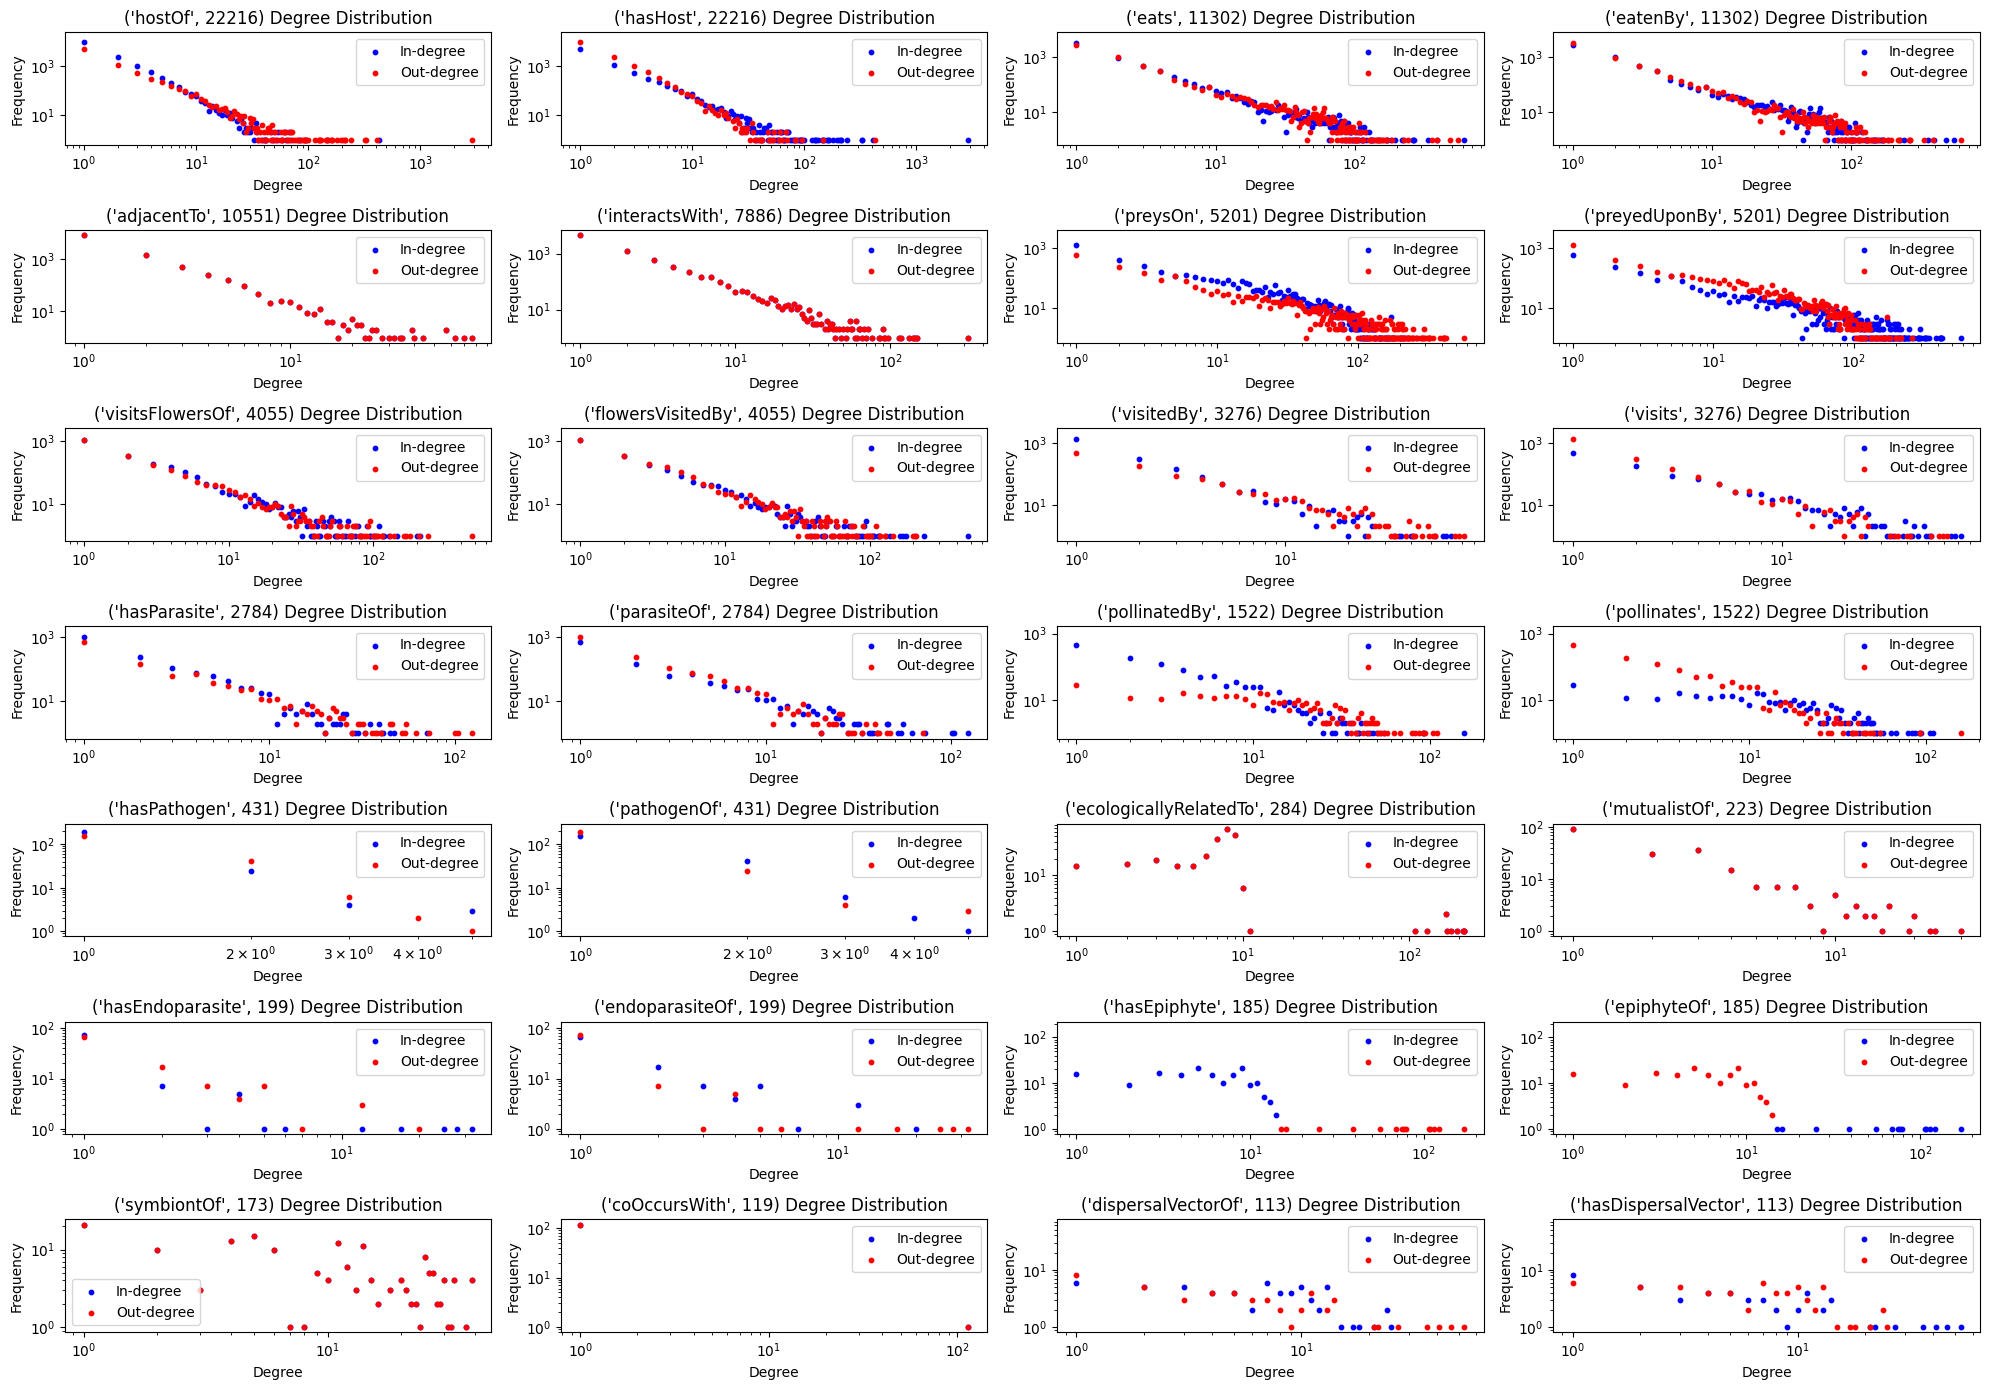

In [122]:
plt.figure(figsize=(20, 14))

for i, interaction in enumerate(sorted_layer):
    plt.subplot(7, 4, i+1)

    subgraph = layers[interaction[0]]

    in_degrees = dict(subgraph.in_degree())
    out_degrees = dict(subgraph.out_degree())

    in_degree_values = sorted(set(in_degrees.values()))
    in_degree_count = [list(in_degrees.values()).count(deg) for deg in in_degree_values]

    out_degree_values = sorted(set(out_degrees.values()))
    out_degree_count = [list(out_degrees.values()).count(deg) for deg in out_degree_values]

    plt.scatter(in_degree_values, in_degree_count, marker='o', color='b', label='In-degree', s=10)
    plt.scatter(out_degree_values, out_degree_count, marker='o', color='r', label='Out-degree', s=10)

    plt.xscale('log')
    plt.yscale('log')

    plt.title(f"{interaction} Degree Distribution")
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.show()


In [125]:
node_overlap = {}

# Calculate node overlap between each pair of layers
for i, interaction1 in enumerate(cleaned_interaction_types):
    for j, interaction2 in enumerate(cleaned_interaction_types):
        if i < j:
            nodes1 = set(layers[interaction1].nodes())
            nodes2 = set(layers[interaction2].nodes())
            overlap = len(nodes1 & nodes2)
            node_overlap[(interaction1, interaction2)] = overlap

print("Node Overlap Between Layers:")
for (interaction1, interaction2), overlap in node_overlap.items():
    print(f"{interaction1} - {interaction2}: {overlap} nodes")


Node Overlap Between Layers:
preysOn - preyedUponBy: 5201 nodes
preysOn - hasParasite: 495 nodes
preysOn - parasiteOf: 495 nodes
preysOn - visitsFlowersOf: 407 nodes
preysOn - flowersVisitedBy: 407 nodes
preysOn - eats: 3310 nodes
preysOn - eatenBy: 3310 nodes
preysOn - hostOf: 693 nodes
preysOn - hasHost: 693 nodes
preysOn - interactsWith: 1075 nodes
preysOn - adjacentTo: 116 nodes
preysOn - hasEndoparasite: 63 nodes
preysOn - endoparasiteOf: 63 nodes
preysOn - coOccursWith: 11 nodes
preysOn - hasEpiphyte: 0 nodes
preysOn - epiphyteOf: 0 nodes
preysOn - visitedBy: 462 nodes
preysOn - visits: 462 nodes
preysOn - symbiontOf: 113 nodes
preysOn - hasPathogen: 35 nodes
preysOn - pathogenOf: 35 nodes
preysOn - pollinatedBy: 192 nodes
preysOn - pollinates: 192 nodes
preysOn - mutualistOf: 23 nodes
preysOn - ecologicallyRelatedTo: 278 nodes
preysOn - dispersalVectorOf: 28 nodes
preysOn - hasDispersalVector: 28 nodes
preyedUponBy - hasParasite: 495 nodes
preyedUponBy - parasiteOf: 495 nodes
pr

In [ ]:
inter_layer_clustering = {}

for interaction in cleaned_interaction_types:
    inter_layer_clustering[interaction] = nx.algorithms.cluster.average_clustering(layers[interaction])

print("Inter-layer Clustering Coefficients:")
for interaction, clustering in sorted(inter_layer_clustering.items(), key=lambda x: x[1], reverse=True):
    if clustering > 0:
      print(f"{interaction}: {clustering}")

Inter-layer Clustering Coefficients:
ecologicallyRelatedTo: 0.3680468181934185
preysOn: 0.11973481463048193
preyedUponBy: 0.11973481463048193
eats: 0.03198360780221063
eatenBy: 0.031983607802210615
interactsWith: 0.01640943610154841
hasParasite: 0.0059302118580383855
parasiteOf: 0.0059302118580383855
hostOf: 0.0012203575002019634
hasHost: 0.0012203575002019634
visitsFlowersOf: 0.0003690665210306611
flowersVisitedBy: 0.0003690665210306611
visitedBy: 0.00016043689165911703
visits: 0.00016043689165911703
adjacentTo: 0.0001284765003843764
hasEndoparasite: 0.0
endoparasiteOf: 0.0
coOccursWith: 0.0
hasEpiphyte: 0.0
epiphyteOf: 0.0
symbiontOf: 0.0
hasPathogen: 0.0
pathogenOf: 0.0
pollinatedBy: 0.0
pollinates: 0.0
mutualistOf: 0.0
dispersalVectorOf: 0.0
hasDispersalVector: 0.0


### Inter Layer Betwenness Centrality

In [11]:
inter_layer_betweenness = {}

for interaction in cleaned_interaction_types:
    # Convert the NetworkX graph to an igraph graph
    G_nx = layers[interaction]
    G_ig = ig.Graph.TupleList(G_nx.edges(), directed=G_nx.is_directed())

    betweenness = G_ig.betweenness(vertices=None, directed=G_nx.is_directed(), cutoff=None, weights=None)

    num_nodes = len(G_ig.vs)
    if num_nodes > 2:
        scale = (num_nodes - 1) * (num_nodes - 2)
    else:
        scale = 1
    normalized_betweenness = [x / scale for x in betweenness]

    inter_layer_betweenness[interaction] = dict(zip(G_ig.vs["name"], normalized_betweenness))


In [28]:
print("Inter-layer Betweenness Centrality:")
for interaction in inter_layer_betweenness.keys():
  i=0
  print(f"Interaction -> '{interaction}':")
  for name, betweenness in sorted(inter_layer_betweenness[interaction].items(), key=lambda x: x[1], reverse=True):
    print(f"\t{name}: {betweenness}")
    i+=1
    if i==3:
      break

Inter-layer Betweenness Centrality:
Interaction -> 'preysOn':
	Polychaeta: 0.02401469993851062
	Nematoda: 0.021480304356130756
	Arachnida: 0.016161414515077636
Interaction -> 'preyedUponBy':
	Polychaeta: 0.02401469993851059
	Nematoda: 0.021480304356130648
	Arachnida: 0.016161414515077414
Interaction -> 'hasParasite':
	Pontania proxima: 1.5692998959224807e-05
	Pontania bridgmanii: 8.626997840547395e-06
	Pontania viminalis: 7.4085839295842614e-06
Interaction -> 'parasiteOf':
	Pontania proxima: 1.569299895922481e-05
	Pontania bridgmanii: 8.626997840547396e-06
	Pontania viminalis: 7.4085839295842614e-06
Interaction -> 'visitsFlowersOf':
	Apis mellifera: 0.032037045925762994
	Asteraceae: 0.029908480015869838
	Apiaceae: 0.014904636733550695
Interaction -> 'flowersVisitedBy':
	Apis mellifera: 0.03203704592576308
	Asteraceae: 0.029908480015870074
	Apiaceae: 0.014904636733550615
Interaction -> 'eats':
	Cephalopoda: 0.006201787220037484
	Micromesistius poutassou: 0.005505089259178558
	Trachurus 

### Multiplexity Matrix

In [ ]:
def calculate_multiplexity(layers):
    multiplexity_matrix = {}

    for layer1_name, graph1 in layers.items():
        multiplexity_matrix[layer1_name] = {}

        for layer2_name, graph2 in layers.items():

            common_edges = set(graph1.edges()).intersection(set(graph2.edges()))
            all_edges = set(graph1.edges()).union(set(graph2.edges()))

            multiplexity_metric = len(common_edges) / len(all_edges)

            multiplexity_matrix[layer1_name][layer2_name] = multiplexity_metric

    return multiplexity_matrix

In [ ]:
multiplexity_matrix = calculate_multiplexity(layers)

In [ ]:
for key, values in multiplexity_matrix.items():
  print(f"Top 3 highest values for {key}:")
  sorted_values = sorted(values.items(), key=lambda item: item[1], reverse=True)
  for i in range(1, 4):
    print(f"\t{sorted_values[i][0]}: {sorted_values[i][1]}")
  print()

Top 3 highest values for preysOn:
	preyedUponBy: 0.8252920649370353
	eats: 0.015757491337732663
	eatenBy: 0.015616023397921345

Top 3 highest values for preyedUponBy:
	preysOn: 0.8252920649370353
	eatenBy: 0.015651386688486917
	eats: 0.015616023397921345

Top 3 highest values for hasParasite:
	parasiteOf: 0.6653735874515095
	symbiontOf: 0.021963169454299714
	interactsWith: 0.021844524937308443

Top 3 highest values for parasiteOf:
	hasParasite: 0.6653735874515095
	symbiontOf: 0.02230860233226297
	interactsWith: 0.019118546101261603

Top 3 highest values for visitsFlowersOf:
	flowersVisitedBy: 0.9312568706485892
	visits: 0.058264652014652016
	visitedBy: 0.05759881027283647

Top 3 highest values for flowersVisitedBy:
	visitsFlowersOf: 0.9312568706485892
	visitedBy: 0.05887069064253808
	interactsWith: 0.058088147469841145

Top 3 highest values for eats:
	eatenBy: 0.9109650818193532
	interactsWith: 0.020950533462657614
	preysOn: 0.015757491337732663

Top 3 highest values for eatenBy:
	eats